First we create a balanced set of images for adapting the weights of naphash 
In order 16384 frames from each of these datasets:
* CelebA https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
* COCO https://cocodataset.org/#home
* Alternative ImageNet datasets  "ImageNetV2"( https://github.com/modestyachts/ImageNetV2 ) and ImageNet-Sketch (https://github.com/HaohanWang/ImageNet-Sketch)
* Fashionpedia Dataset https://fashionpedia.github.io/home/Fashionpedia_download.html
* iNaturalist dataset 2019 https://www.kaggle.com/c/inaturalist-2019-fgvc6
* Places365-Standard http://places2.csail.mit.edu/download.html
* ImageNet fall11 Release https://www.image-net.org/

This will also load the images, calculate the dct, and store it on disk for faster weight adaption training and testing

In [1]:
%load_ext autoreload
%autoreload 2
#There are three hyper-parameters for weight adaption session:
dct_dim = 32
min_img_dims = 128
trg_num_samples = 16384 #largest power of two which can fit in the individual dataset sizes (Places365 is 36500 but with the potential amount of large/small images we stay on the cautious side)

#Experimental switches:
use_pil_rz = False #uses PIL LANCZOS for downsampling instead of opencv INTER_AREA  
num_threads = 8 #use multi-core procedures with this many cores where possible

Each dataset as a different number of samples and some contain a different degree of images too small for use (128x128 is used as a minimum)

In [2]:
import gzip
import json
import glob
seekall = '/workspace/data/data/imagenet_fall11/fall11_whole.seekhelper.txt.gz'
def load_from_gz(filepath, tar_root_folder="", as_list_style=True):
    if as_list_style:
        info = []
    else:
        info = {}
    with gzip.open(filepath, 'rb') as f_in:
        for line in f_in:
            if as_list_style:
                info.append(tar_root_folder+line.decode('ascii'))
            else:
                l_sp = line.decode('ascii').split(':')
                info[l_sp[0]] = [int(l_sp[1]),int(l_sp[2])]
    return info

def load_from_seekhelper(dir0):
    if not dir0[-1] == '/':
        dir0+='/'
    return [dir0+p for p in load_from_gz(dir0+'.seekhelper.txt.gz')]
imgnet_alt_paths = load_from_seekhelper('/workspace/data/data/imagenet_alt/')
fashionpedia_paths = load_from_seekhelper('/workspace/data/data/fashionpedia/')
inat2019_paths = load_from_seekhelper('/workspace/data/inat2019/')
places365_paths = load_from_seekhelper('/workspace/data/places365/')
celeba_paths = load_from_seekhelper('/workspace/data/celeba/jpg256')

imgnet_root='/workspace/data/data/imagenet_fall11/'
imgnet_paths = load_from_seekhelper(imgnet_root)
coco_inp_dir = '/workspace/data/data/coco/images/train2017'
coco_paths = sorted(glob.glob(coco_inp_dir+'/*.jpg'))

In [3]:
import random
train_paths = [celeba_paths, coco_paths, imgnet_alt_paths, fashionpedia_paths, inat2019_paths, places365_paths, imgnet_paths]

In [4]:
print([len(p) for p in train_paths])

[70000, 118287, 53542, 48823, 303593, 36500, 14197087]


In [5]:
import numpy as np
precalc_dcts = np.load('ordered_dct_balanced.npz')
skip_paths = set([s.strip() for s in precalc_dcts['paths'].tolist()])

In [6]:
#normalize sets and take smaller subsample
trg_num_samples_use = int(trg_num_samples*1.25) #about 12% of imagenet frames have one dimension smaller than 128 -> add double for buffer; will be straightened later
all_paths_balanced = []
skipped_cnt = 0
for t in train_paths:
    t0 = t[:]
    random.shuffle(t0)
    t1 = []
    for t in t0:
        if t.strip() in skip_paths:
            skipped_cnt += 1
            continue
        t1.append(t)
        if len(t1) >= trg_num_samples_use:
            break
    all_paths_balanced += t1
print("Skipped ",skipped_cnt)

Skipped  46520


In [7]:
#Uncomment to recreate the original data paths 
#!gunzip ordered_paths_balanced.txt.gz
#with open('ordered_paths_balanced.txt', 'r') as f_out:
#    all_paths_balanced = [p for p in f_out]

In [176]:
from async_dct_loader import async_load_dct_paths, tqdm_nb
from build.naphash_cpp import naphash as nhcpp, rot_inv_type
nhcpp_objs = [nhcpp(dct_dim=dct_dim, rot_inv_mode=rot_inv_type.none, apply_center_crop=False, is_rgb=False) for _ in range(num_threads)] #no center crop
#all_dct = load_dct_paths(nhcpp_objs, all_paths_balanced, num_threads=8, dct_dim=dct_dim, min_img_dims=min_img_dims)
dcts = await async_load_dct_paths(nhcpp_objs, all_paths_balanced, num_threads, dct_dim, min_img_dims, tqdm_vers=tqdm_nb, pil_sz=32)

In [168]:
#path_per_ds1 = dict(path_per_ds)

In [9]:
import numpy as np
def dataset_by_path(p):
    path_context = ['/celeba/','/coco/','/imagenet_alt/', '/fashionpedia/','/inat2019/','/places365/', '/imagenet_fall11/']
    for i,c in enumerate(path_context):
        if c in p: return i
    return -1
orig_dct, all_bu, count_ds, path_per_ds = [], [], {}, {i:[] for i in range(7)}
all_paths_balanced = paths
for i in range(len(all_paths_balanced)):
    #if dcts[i] is None:
    #    continue
    idx_dataset = dataset_by_path(all_paths_balanced[i])
    if count_ds.get(idx_dataset,0) > trg_num_samples:
        continue
    path_per_ds[idx_dataset].append(all_paths_balanced[i])
    count_ds[idx_dataset] = count_ds.get(idx_dataset,0) + 1  
    all_bu.append(all_paths_balanced[i])
    #orig_dct.append(dcts[i].reshape(1024))
#orig_dct = np.vstack(orig_dct)
print(count_ds)

{0: 16385, 1: 16385, 2: 16385, 3: 16385, 4: 16385, 5: 16385, 6: 16385}


In [10]:
import json
json.dump(path_per_ds,open('testset_paths.json', 'wt'))

In [185]:
np.savez_compressed('ordered_dct_pil_testing.npz', dcts=orig_dct, paths=all_bu)

In [1]:
with open('ordered_paths_balanced.txt', 'wt') as f_out:
    for p in all_bu:
        f_out.write(p.replace('\n','')+'\n')

NameError: name 'all_bu' is not defined

In [28]:
!gzip ordered_paths_balanced.txt

Below is code to pre-calculate nap hashes for the CIFAR10 dataset

In [8]:
from async_dct_loader import async_load_dct_paths, tqdm_nb
from build.naphash_cpp import naphash as nhcpp, rot_inv_type
from cifar10_trainer import files_in_subdirs

cifar10_train = list(sorted(files_in_subdirs('./cifar10/train')))
cifar10_val = list(sorted(files_in_subdirs('./cifar10/test')))

nhcpp_objs = [nhcpp(dct_dim=dct_dim, rot_inv_mode=rot_inv_type.none, apply_center_crop=False, is_rgb=False) for _ in range(num_threads)] #no center crop
#all_dct = load_dct_paths(nhcpp_objs, all_paths_balanced, num_threads=8, dct_dim=dct_dim, min_img_dims=min_img_dims)
dcts = await async_load_dct_paths(nhcpp_objs, cifar10_val+cifar10_train, num_threads, dct_dim, -1, tqdm_vers=tqdm_nb)


In [9]:
import numpy as np
np.savez_compressed('cifar10_dcts.npz', dcts=np.vstack([d.reshape(1024) for d in dcts]), paths=list(cifar10_val+cifar10_train))

In [43]:
import numpy as np
from async_dct_loader import async_hash_dcts, tqdm_nb
from build.naphash_cpp import naphash as nhcpp, rot_inv_type
from cifar10_trainer import files_in_subdirs
num_threads, dct_dim = 8, 32
precalc_dcts = np.load('ordered_dct_testing.npz')
cifar_dcts, paths = precalc_dcts['dcts'],  precalc_dcts['paths']
nhcpp_objs = [nhcpp(dct_dim=dct_dim, rot_inv_mode=rot_inv_type.none, apply_center_crop=False, is_rgb=False) for _ in range(num_threads)] #no center crop
#all_dct = load_dct_paths(nhcpp_objs, all_paths_balanced, num_threads=8, dct_dim=dct_dim, min_img_dims=min_img_dims)
hashes = await async_hash_dcts(nhcpp_objs, cifar_dcts, num_threads, tqdm_vers=tqdm_nb)

In [187]:
np.savez_compressed('ordered_dct_testing_pil_notr.npz', hashes=np.vstack(hashes), paths=paths)

In [2]:
from async_dct_loader import async_load_dct_paths
cifar10_train = list(sorted(files_in_subdirs('./cifar10/train')))
cifar10_val = list(sorted(files_in_subdirs('./cifar10/test')))
hashes2 = await async_load_dct_paths(nhcpp_objs, cifar10_val+cifar10_train, num_threads, dct_dim, -1, tqdm_vers=tqdm_nb, ret_hash = True)

In [32]:
from async_dct_loader import async_load_dct_paths
hashes_ph6 = await async_load_dct_paths(nhcpp_objs, paths, num_threads, dct_dim, -1, tqdm_vers=tqdm_nb, ret_hash = True, phsz=7)
hashes_ph8 = await async_load_dct_paths(nhcpp_objs, paths, num_threads, dct_dim, -1, tqdm_vers=tqdm_nb, ret_hash = True, phsz=8)
hashes_ph18 = await async_load_dct_paths(nhcpp_objs, paths, num_threads, dct_dim, -1, tqdm_vers=tqdm_nb, ret_hash = True, phsz=12)

In [6]:
all([(hashes[i] == hashes2[i]).all() for i in range(len(hashes))])

True

In [10]:
np.savez_compressed('cifar10_hashes.npz', hashes=np.vstack(hashes), paths=list(cifar10_val+cifar10_train))

In [18]:
paths[0]

'/workspace/data/celeba/jpg256/resized_256_jpgs.tar/65212.jpg:1937091072:25625'

In [44]:
hashes0 = {}
paths1 = [p.strip() for p in paths]
for k, v in path_per_ds.items():
    all_h = []
    for p in v:
        i0 = paths1.index(p.strip())
        all_h.append(hashes[i0])
    hashes0[k] = np.vstack(all_h)    

In [197]:
hashes0[0].shape

(16385, 1024)

In [39]:
hashes0[0][:,4].shape

(16385,)

In [22]:
c0 = calc_inter_dist(hashes0[0],1024)

In [31]:

#np.mean(c1,axis=0)

In [21]:
h = hashes0[0][:,:5]
dists0 = calc_inter_dist(h,1024)
dists0 = np.float32(dists0)
dists0[dists0 > 1023] = np.nan
m_mean = np.int32(np.nanmean(dists0,axis= 1)+0.5)
m_max = np.int32(np.nanmax(dists0,axis= 1)+0.5)
m_min = np.int32(np.nanmin(dists0,axis= 1)+0.5)


In [27]:
v0,c0 = np.unique(m_max, return_counts=True)

<BarContainer object of 9 artists>

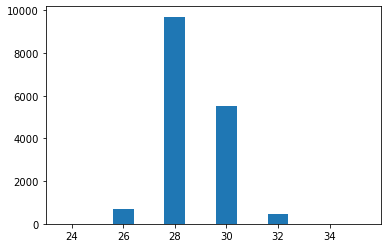

In [25]:
v1,c1 = [(min(v0)-2),(min(v0)-1)]+v0.tolist()+[(max(v0)+1),(max(v0)+1)],[0,0]+c0.tolist()+[0,0]
plt.bar(v1,c1)

In [28]:
v0,c0

(array([26, 28, 30, 32, 34], dtype=int32),
 array([ 694, 9697, 5527,  465,    2]))

<BarContainer object of 5 artists>

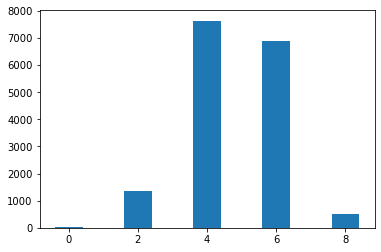

In [20]:
plt.bar(v0,c0)

In [ ]:
if len(vals) < 6:
    if min(vals) > 2:
        vals = [(min(vals)-2),(min(vals)-1)]+vals.tolist()+[(max(vals)+1),(max(vals)+2)]
        counts = [0,0]+c0.tolist()+[0,0]
    else:
        vals = vals.tolist()+[(max(vals)+i) for i in range(1,5)]
        counts = c0.tolist()+[0,0,0,0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


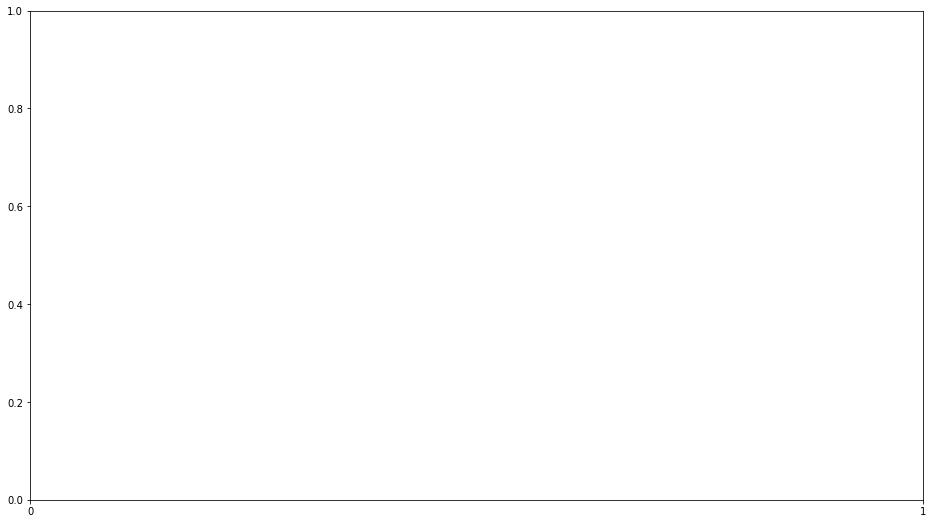

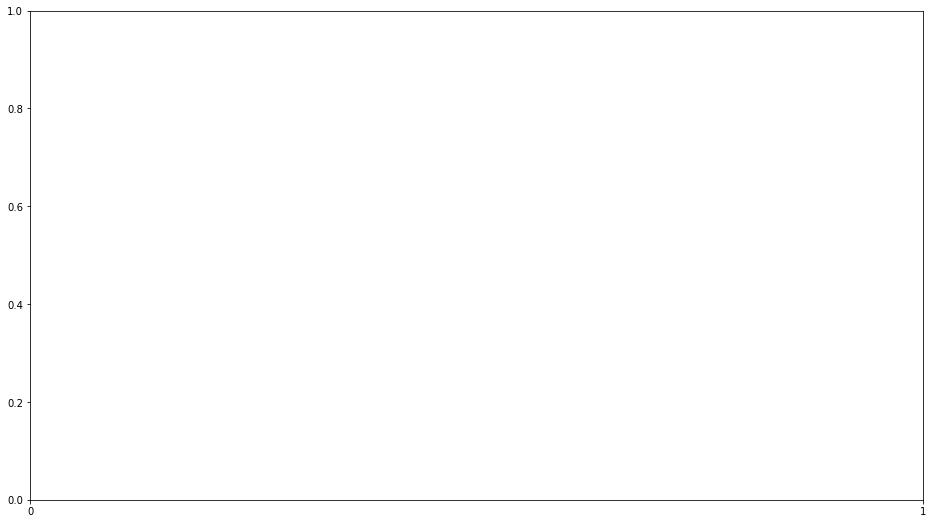

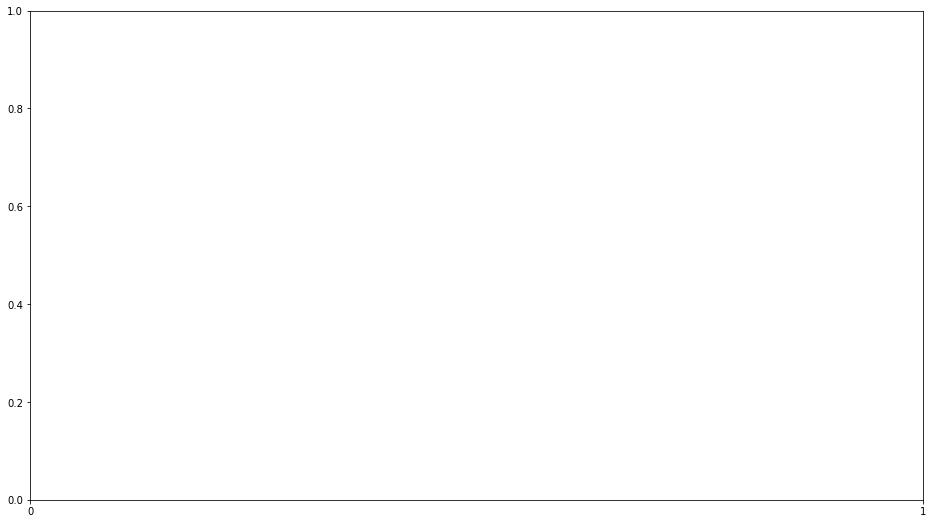

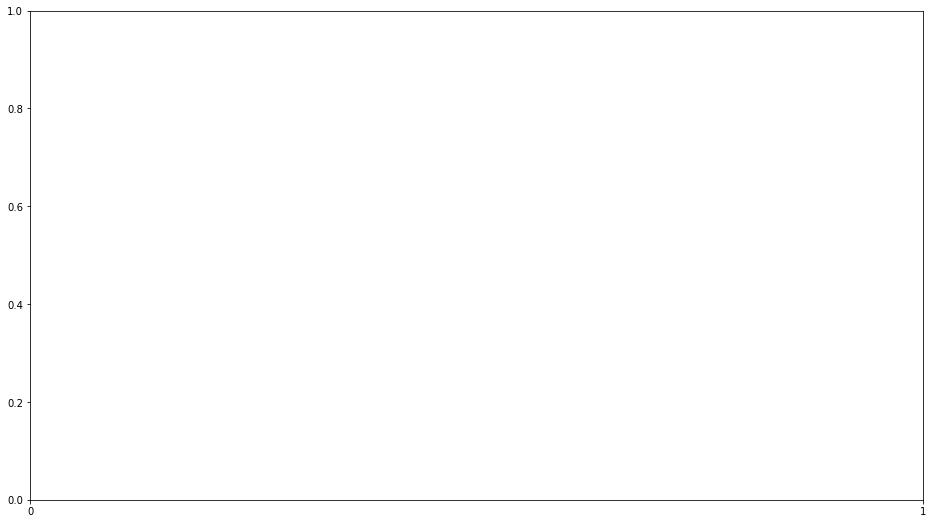

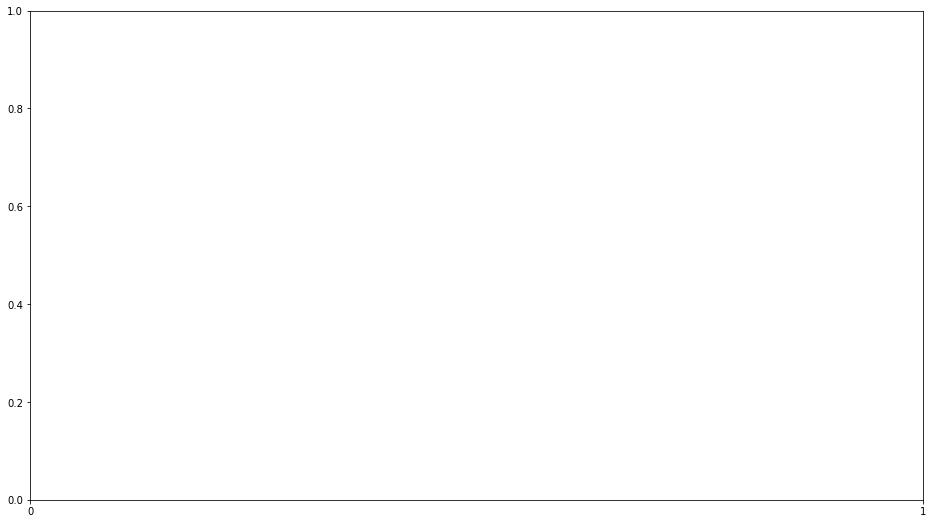

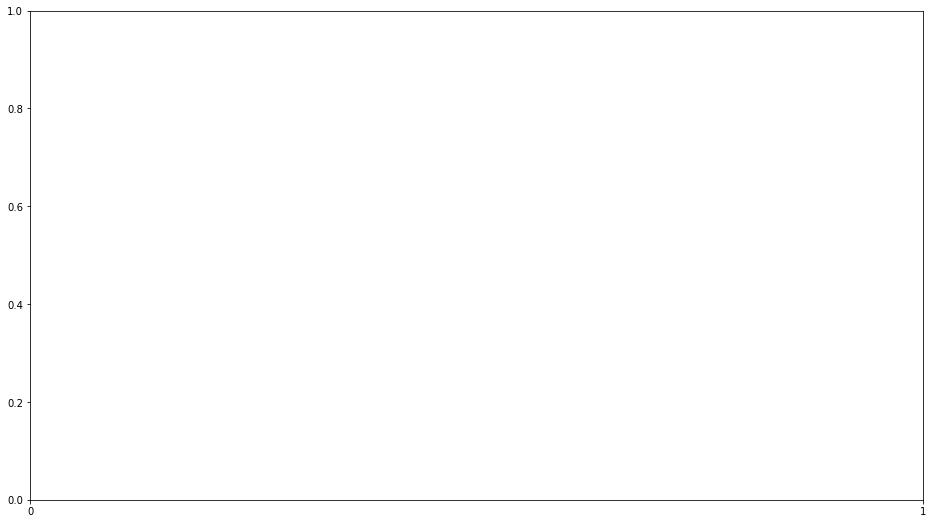

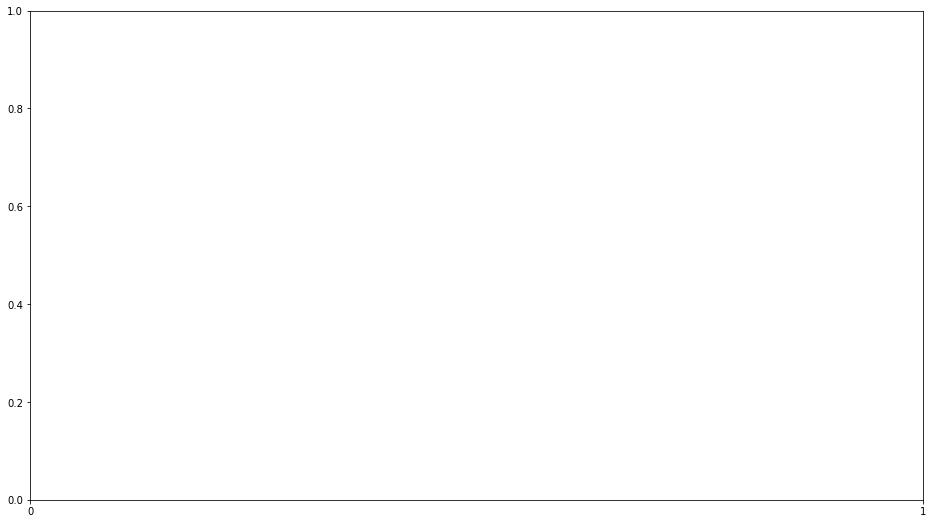

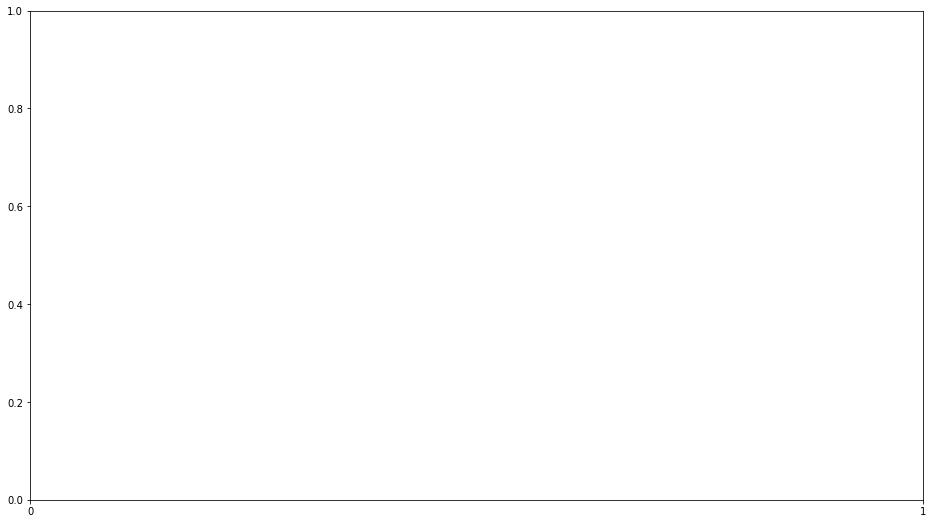

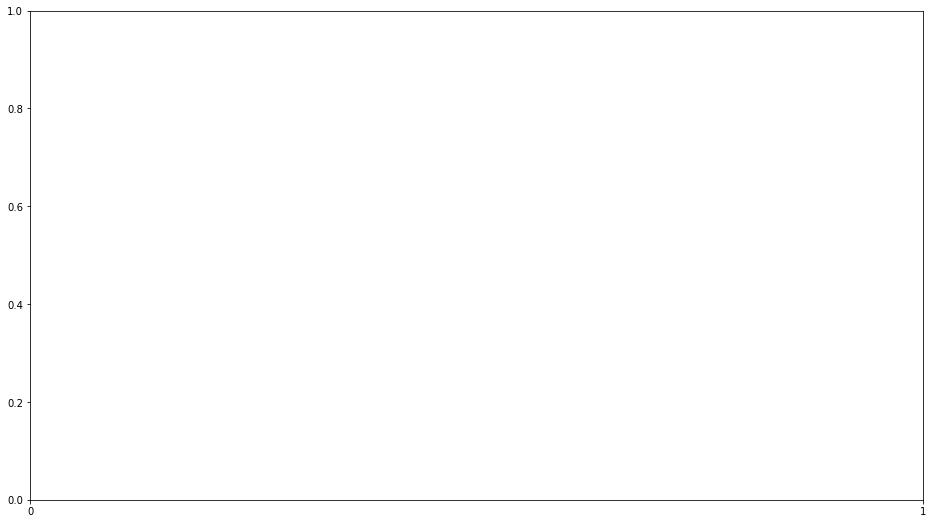

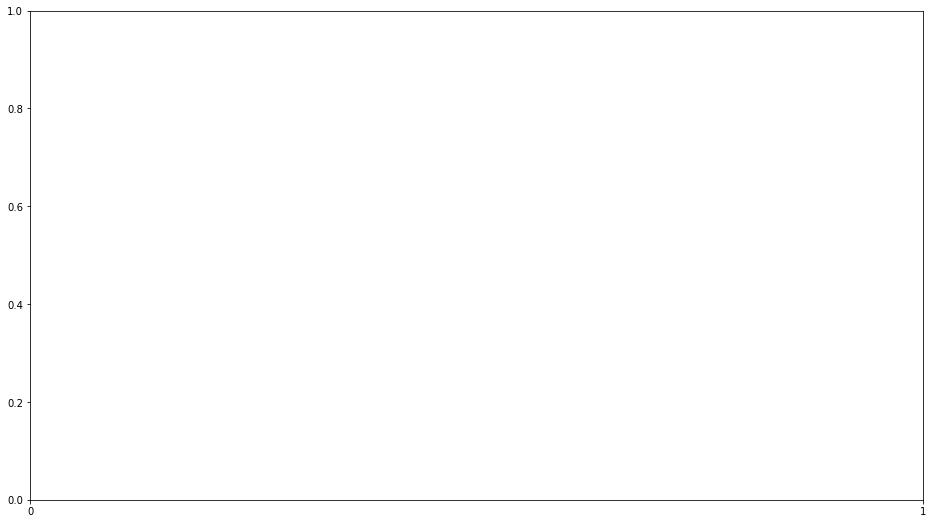

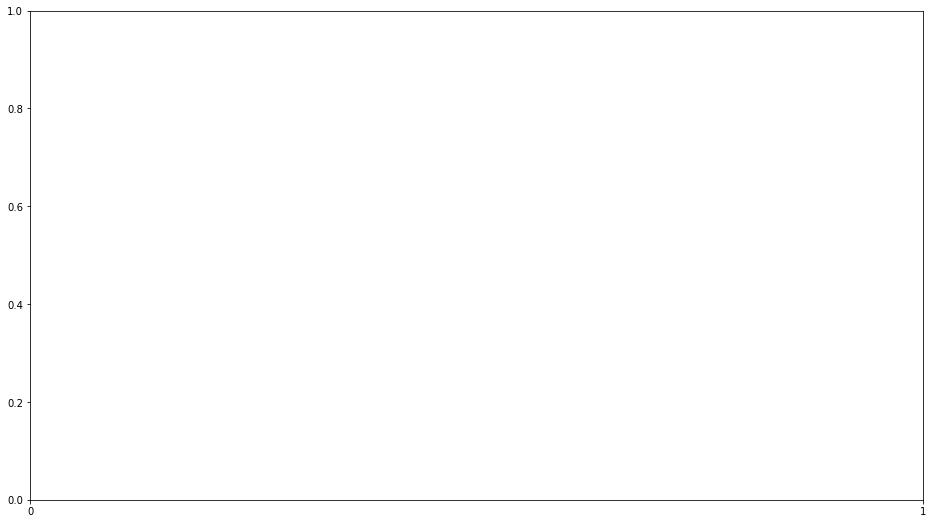

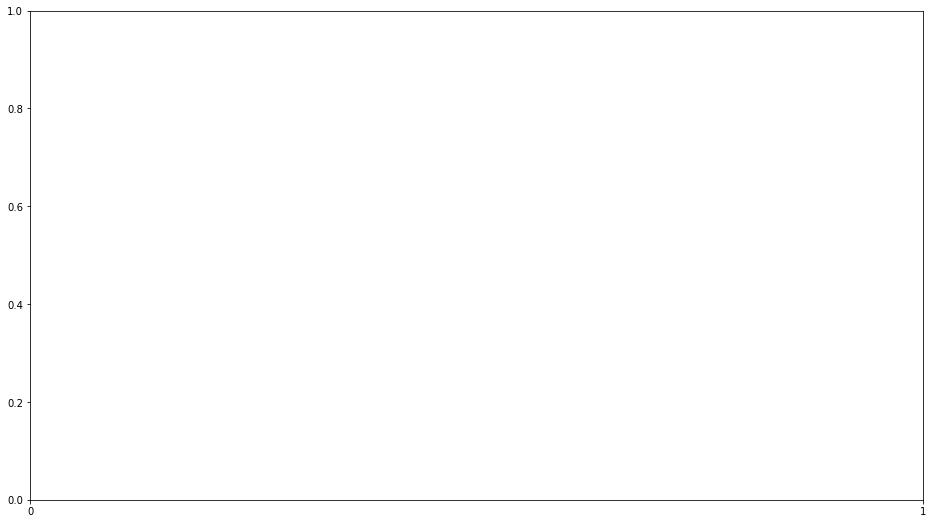

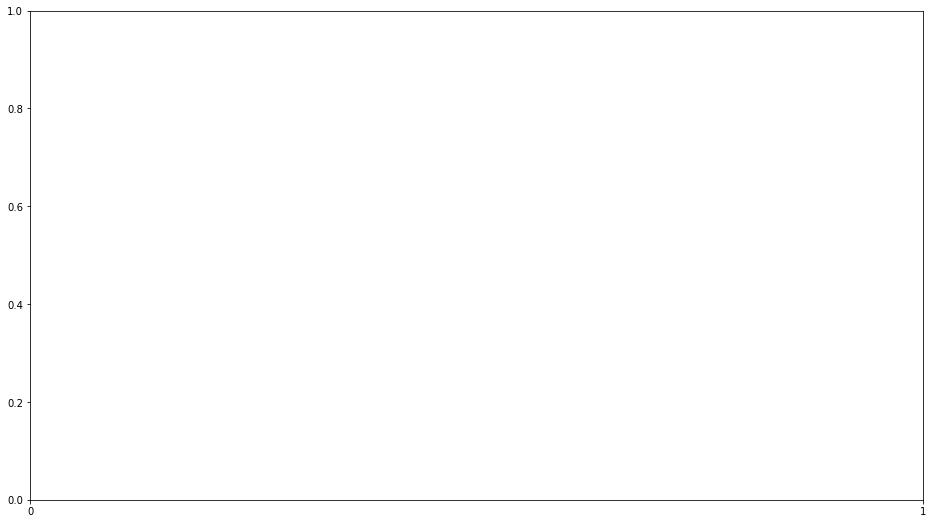

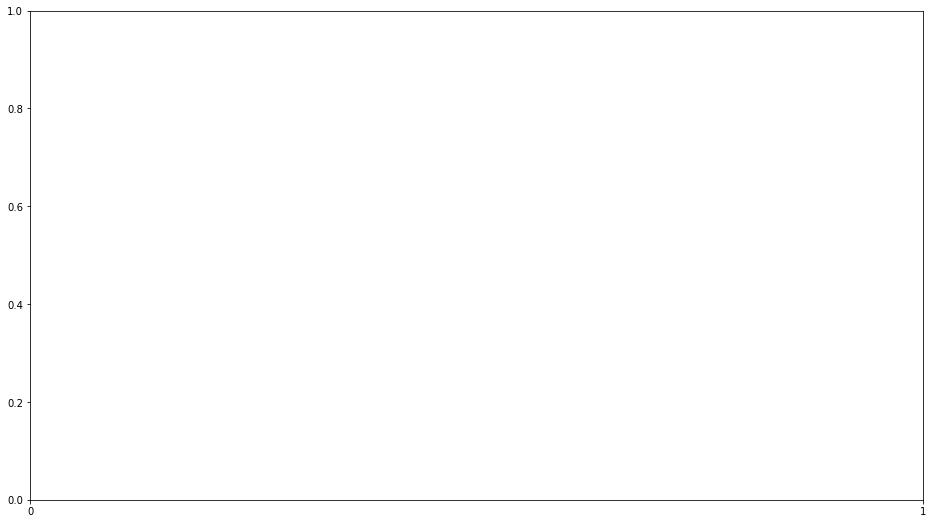

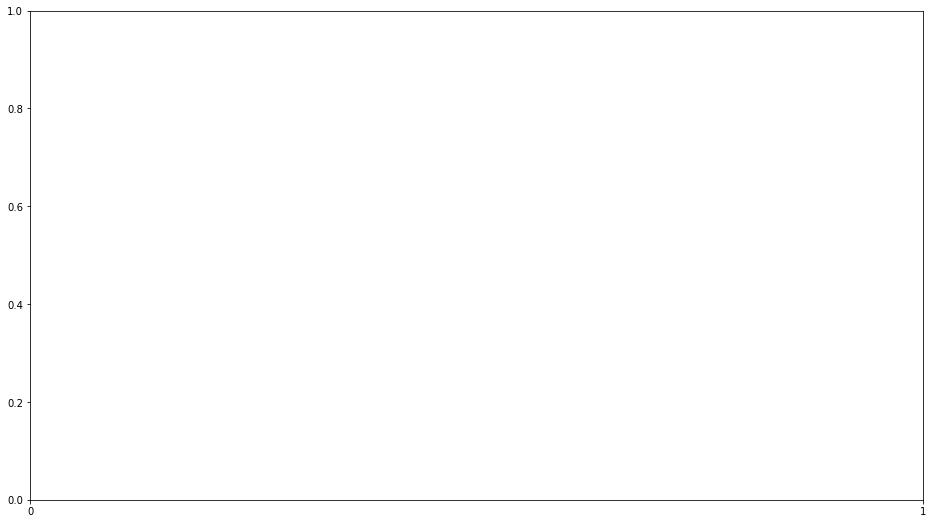

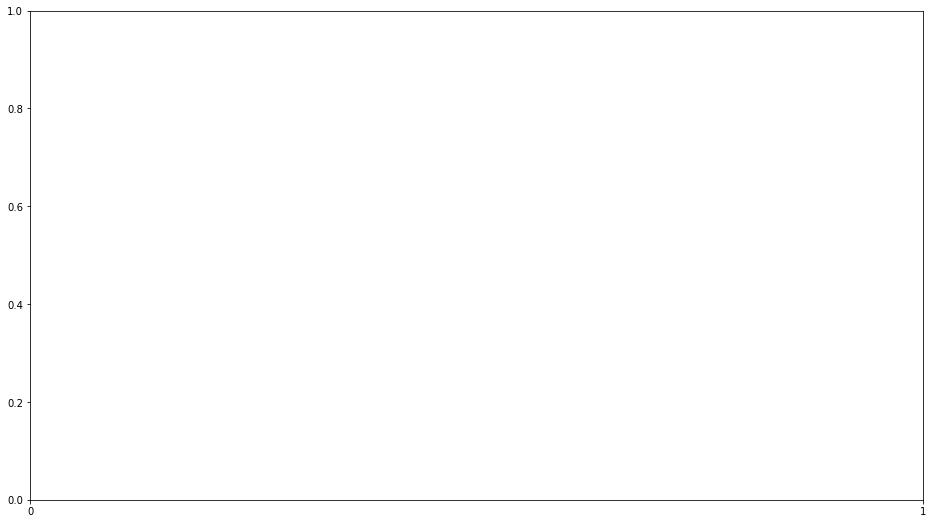

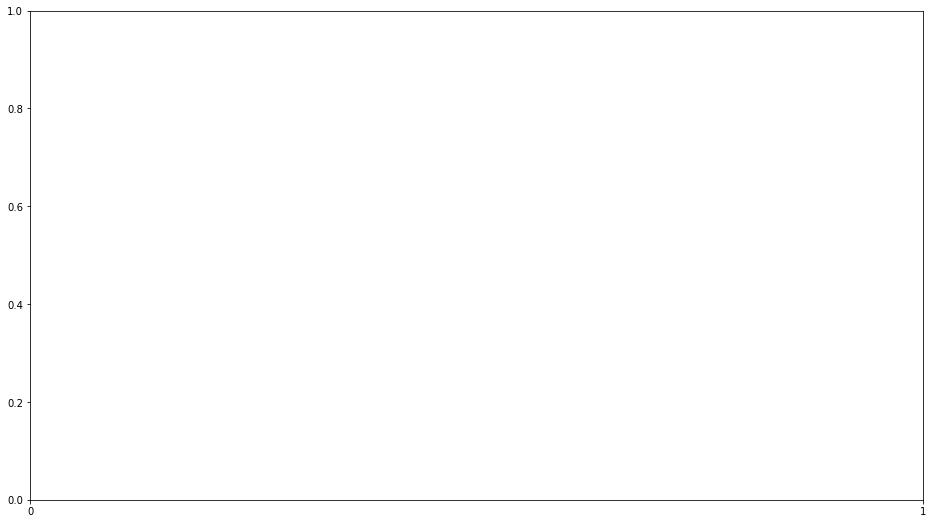

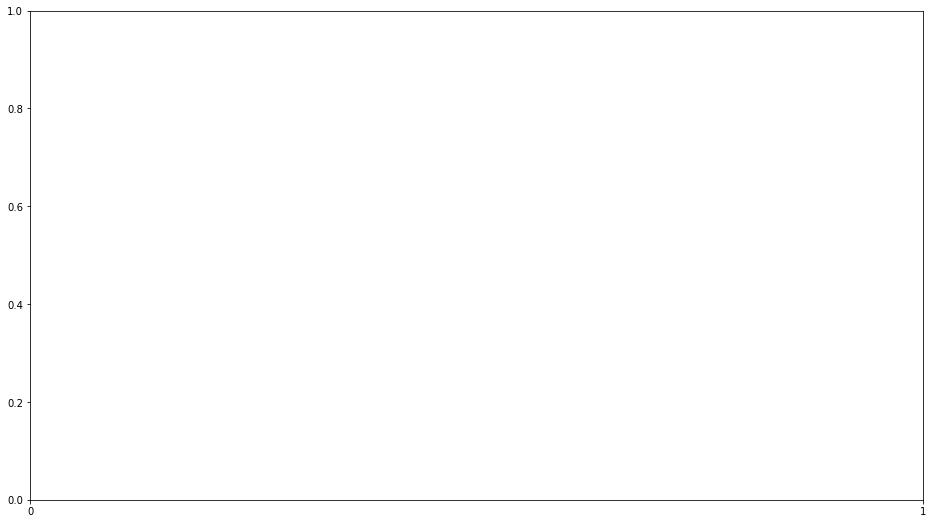

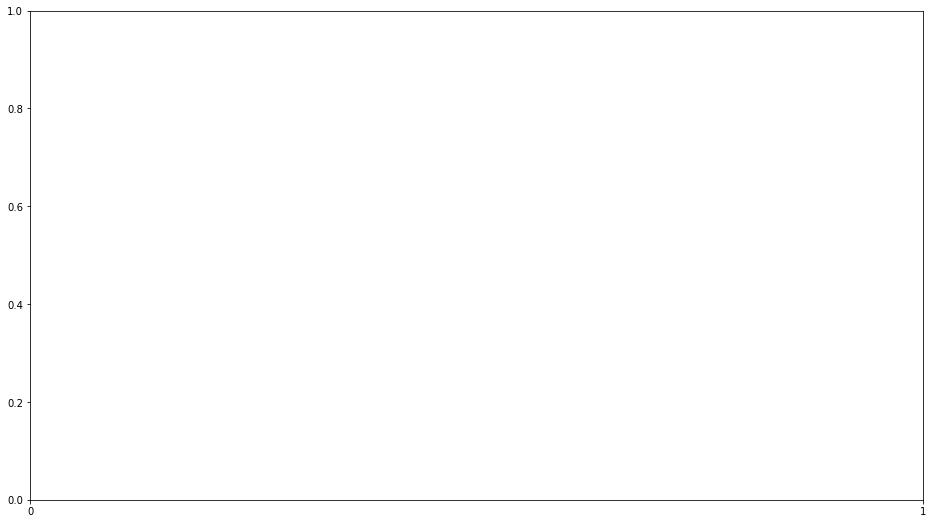

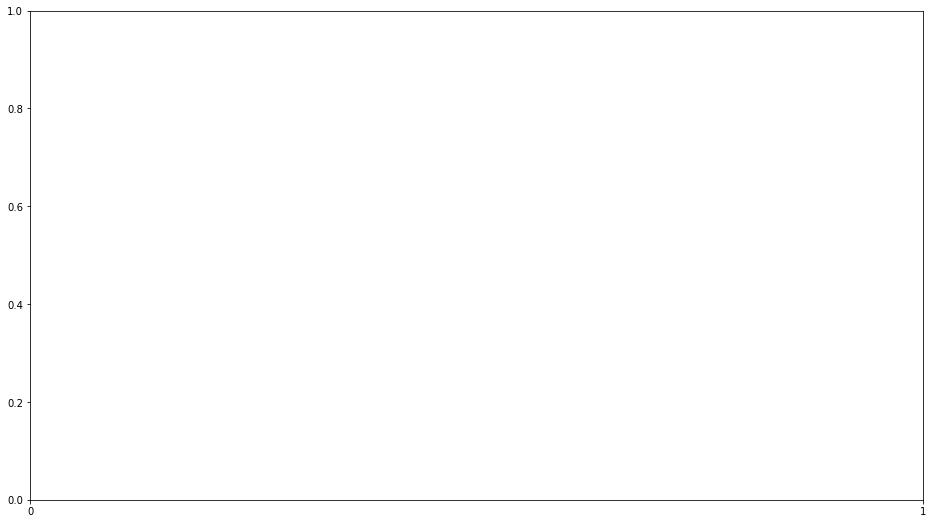

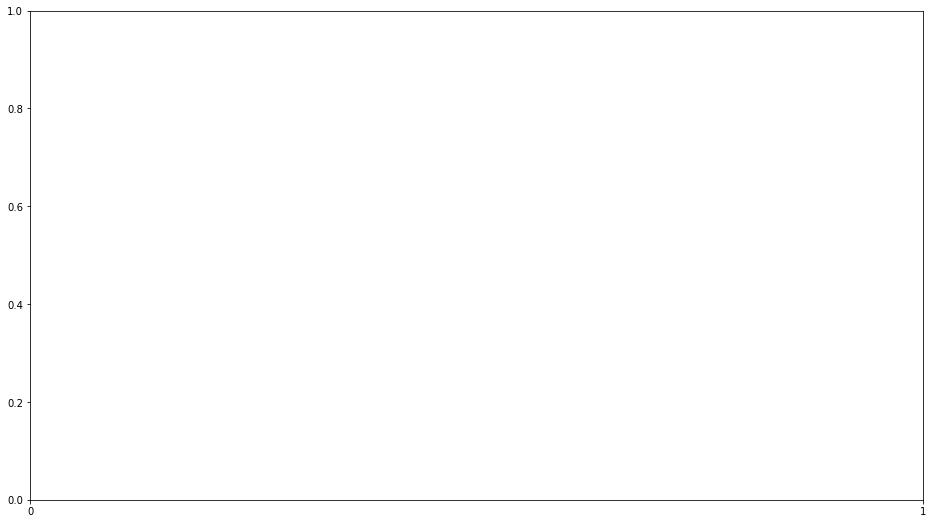

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import json
from tqdm.notebook import tqdm as tqdm_nb

from async_dct_loader import load_img_tar
import cv2

def load_cntr(path0, dim=128):
    i0 = load_img_tar(path0)
    fx = dim/i0.shape[0]
    x0, y0 = (int(i0.shape[1]*fx+0.5)-dim)//2, 0
    if i0.shape[0] > i0.shape[1]:
        fx = dim/i0.shape[1]
        x0, y0 = 0, (int(i0.shape[0]*fx+0.5)-dim)//2
    return cv2.resize(i0,(0,0),fx=fx,fy=fx,interpolation=cv2.INTER_AREA)[y0:(y0+dim),x0:(x0+dim)]

def vis_pairs(pairs0,paths, dim=128):
    loaded_pairs = []
    spacer=np.ones((dim,dim//8,3),np.uint8)*255
    for (p0,p1) in pairs0:
        i0 = load_cntr(paths[p0], dim=dim)
        i1 = load_cntr(paths[p1], dim=dim)
        loaded_pairs+=[i0,i1,spacer]
    return loaded_pairs

def cls_fig():
    plt.close() 
    plt.subplots(figsize=(16, 9))
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

def get_hash_dists(h, name0, paths, distname='naph0'):
    name0 = name0+'_'
    dists0 = calc_inter_dist(h,1024)
    dists0 = np.float32(dists0)
    dists0[dists0 > 1023] = np.nan
    m_mean = np.int32(np.nanmean(dists0,axis= 1)+0.5)
    m_max = np.int32(np.nanmax(dists0,axis= 1)+0.5)
    m_min = np.int32(np.nanmin(dists0,axis= 1)+0.5)
    v0,c0 = np.unique(m_mean, return_counts=True)
    v1,c1 = np.unique(m_max, return_counts=True)
    v2,c2 = np.unique(m_min, return_counts=True)
    jdata = {}
    plt.subplots(figsize=(16, 9))
    for store_one in [True,False]:
        for (vals, counts, name1) in [(v0,c0,'mean'),(v1,c1,'max'),(v2,c2,'min')]:
            if store_one: 
                cls_fig()
                jdata[name1+'_v'] = [int(i) for i in v0]
                jdata[name1+'_c'] = [int(i) for i in c0]
            plt.bar(vals, counts, label=name0+name1+' dists')
            plt.legend()
            if store_one: plt.savefig('hist_'+distname+'_'+name0+name1+'.png')  
        if not store_one: plt.savefig('hist_'+distname+'_'+name0+'all.png')
        cls_fig()
    #show nearest hits
    np.nan_to_num(dists0, nan=1024, copy=False)
    dists0 = np.int32(dists0)
    pairs0, dists0 = find_closest(m_min, dists0)
    jdata.update({'pairs':pairs0,'dists':dists0,'name0':name0})
    json.dump(jdata, open('hist_'+distname+'_nearest_'+name0+'.json','wt'))
    nearest_matches = np.hstack(vis_pairs(pairs0,paths))
    cv2.imwrite('hist_'+distname+'_nearest_'+name0+'.jpg',nearest_matches)
    
def find_closest(m_min, c0, max_num=8):
    solved_pairs = []
    ret_pairs, ret_dists = [], []
    best_ord = np.argsort(m_min)
    for p0 in best_ord:
        if p0 in solved_pairs:
            continue
        p1 = np.argmin(c0[p0])
        if p1 in solved_pairs:
            continue
        ret_pairs.append((int(p0),int(p1)))
        solved_pairs.append(p0)
        solved_pairs.append(p1)
        ret_dists.append(int(c0[p0,p1]))
        if len(ret_pairs) >= max_num:
            break
    return ret_pairs, ret_dists

ds_names = ['celeba','coco','imgnetalt', 'fashionp','inat2019','places365', 'imgnetf11']
for i in tqdm_nb(range(7)):
    get_hash_dists(hashes0[i][:,:6],ds_names[i]+'_6', path_per_ds[i])
    get_hash_dists(hashes0[i][:,:8],ds_names[i]+'_8', path_per_ds[i])
    get_hash_dists(hashes0[i][:,:18],ds_names[i]+'_18', path_per_ds[i])

In [165]:
!rm hist_*_6\ *
!rm hist_*_8\ *
!rm hist_*_40\ *

In [53]:
!rename

/bin/sh: 1: man: not found


In [47]:
!rm hist_*.png
!rm hist_*.jpg
!rm hist_*.json

In [50]:
!zip hist_naph.zip hist_*

  adding: hist_naph0_celeba_18_all.png (deflated 23%)
  adding: hist_naph0_celeba_18_max.png (deflated 36%)
  adding: hist_naph0_celeba_18_mean.png (deflated 36%)
  adding: hist_naph0_celeba_18_min.png (deflated 35%)
  adding: hist_naph0_celeba_6_all.png (deflated 32%)
  adding: hist_naph0_celeba_6_max.png (deflated 41%)
  adding: hist_naph0_celeba_6_mean.png (deflated 40%)
  adding: hist_naph0_celeba_6_min.png (deflated 39%)
  adding: hist_naph0_celeba_8_all.png (deflated 31%)
  adding: hist_naph0_celeba_8_max.png (deflated 37%)
  adding: hist_naph0_celeba_8_mean.png (deflated 41%)
  adding: hist_naph0_celeba_8_min.png (deflated 37%)
  adding: hist_naph0_coco_18_all.png (deflated 22%)
  adding: hist_naph0_coco_18_max.png (deflated 35%)
  adding: hist_naph0_coco_18_mean.png (deflated 39%)
  adding: hist_naph0_coco_18_min.png (deflated 35%)
  adding: hist_naph0_coco_6_all.png (deflated 32%)
  adding: hist_naph0_coco_6_max.png (deflated 42%)
  adding: hist_naph0_coco_6_mean.png (deflated

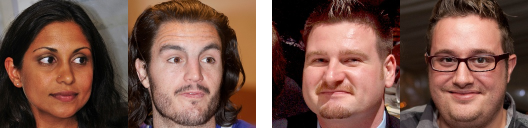

In [104]:
from PIL import Image as pi
from IPython import display as disp0
import numpy as np
import cv2
def show_im(img, is_bgr=True):
    if is_bgr and len(img.shape) > 2 and img.shape[2] == 3:
        img = img[...,::-1] #PIL needs RGB instead of opencv's BGR
    if img.dtype != np.uint8:
        img = (img * (255.499/np.max(img))).astype(np.uint8)  #automatically change HDR range to LDR
    show_impil(pi.fromarray(img))
def show_impil(img):
    disp0.display(img)
def vis_cifar(ids, paths, max_num = 16, fx=2.0):
    ims = [cv2.resize(cv2.imread(paths[i]),(0,0),fx=fx,fy=fx,interpolation=cv2.INTER_NEAREST) for i in ids[:max_num]]
    show_im(np.hstack(ims))

show_im(np.hstack([i0,i1,spacer,i2,i3]))

In [31]:
#pip install imagehash
from async_dct_loader import pip_phash, load_img_tar
import cv2
i0 = load_img_tar(paths[0])
pip_phash(i0,4)

array([147,  39], dtype=uint8)